# Sharp Variables Analysis
This notebook is for the analysis of different variables related to solar flares and flux emergence.
1.	Why do some flaring active regions have rapid flux emergence before a flare and some don’t?
 - This is similar to the previous question of how does flux emergence relate to flaring, except now we are specifically looking at flaring regions, and trying to determine the factors that lead to flares.
 - Alternative version of the question: how do we know when a flaring active region will flare? Does it depend on flux emergence?
2.	Why do some rapid flux emergences flare and others don’t?
3.	Are there natural clusters of data given some physical variables?
 - Questions 1 and 2 will inform this question.
 - This question is an unsupervised learning problem.

In [81]:
import sys
import math
import random
import matplotlib.pyplot as plt
import scipy
import numpy

from notebook_import import NotebookFinder
sys.meta_path.append(NotebookFinder())
import flux_emergence_analysis as fea

In [2]:
harp_ids, harp_noaa_dict = fea.get_harp_ids_and_harp_noaa_dict()
flare_data = fea.get_noaa_data_from_csv()
print('Number of active regions:', len(harp_ids))
print('Number of flares:', len(flare_data))

flare_time_dict = fea.get_harp_id_to_flaring_times_dict(harp_noaa_dict, flare_data)

Number of active regions: 1335
Number of flares: 8029


In [3]:
def get_segmented_data(harp_ids, flare_time_dict, n=None, return_harp_ids=False, num_hours=24):
    '''This method returns two arrays: x and y. The x array includes time series
    data, while y represents whether the corresponding active region in x flared.
    
    The x and y arrays are built according to the following rule:
        - If a flare occurs within 24 hours after sample time t, it is considered
        to belong to the positive case (i.e. the corresponding y entry will be True).
        - If no flare occurs within 24 hours, it is considered to belong to the
        negative case.
    
    The x array is an array of arrays, where each array represents a 24-hour set of
    data corresponding to an active region. Each of these 24-hour arrays are arrays of
    dictionaries representing the data at each recorded interval within the 24 hours.
    
    The n parameter refers to how many negative data points. If n is set to None (default),
    then the number of negative data points = the number of positive data points.
    '''
    num_no_flare = 0
    num_flares = 0
    for harp_id in harp_ids:
        data = flare_time_dict[harp_id]
        if not data: num_no_flare += 1
        num_flares += len(data)
    if n != None:
        num_samples_per_datapoint = math.ceil(n / num_no_flare)
    else:
        n = num_flares
        num_samples_per_datapoint = math.ceil(num_flares / num_no_flare)
    x = []
    y = []
    harp_list = []
    num_negative = 0
    for harp_id in harp_ids:
        keys = fea.read_data(harp_id)
        flare_data = flare_time_dict[harp_id]
        if flare_data:
            for flare_time in flare_data:
                # Throw out flare data with less than 24 hours of preceding data
                if flare_time - keys.TIME[0] > num_hours and flare_time < keys.TIME.iloc[-1]:
                    data = []
                    for i, time in enumerate(keys.TIME):
                        if time <= flare_time and time >= flare_time - num_hours:
                            data.append({'time': time, 'flux': keys.USFLUX[i],
                                        'free_energy': keys.TOTPOT[i], 'area': keys.AREA_ACR[i],
                                        'polarity_inversion_flux': keys.R_VALUE[i]})
                    if not data or data[-1]['time'] - data[0]['time'] < num_hours - 1:
                        # Insufficient data
                        continue
                    x.append(data)
                    harp_list.append(harp_id)
                    y.append(True) # True => flare is present
        else:
            if len(keys.TIME) <= 0 or keys.TIME.iloc[-1] - keys.TIME[0] < num_hours or \
                (n != None and num_negative >= n): continue
            for _ in range(num_samples_per_datapoint):
                end = keys.TIME[0]
                while end - keys.TIME[0] < num_hours:
                    end = keys.TIME[random.randrange(len(keys.TIME))]
                data = []
                for i, time in enumerate(keys.TIME):
                    if time <= end and time >= end - num_hours:
                        data.append({'time': time, 'flux': keys.USFLUX[i],
                                    'free_energy': keys.TOTPOT[i], 'area': keys.AREA_ACR[i],
                                    'polarity_inversion_flux': keys.R_VALUE[i]})
                if not data or data[-1]['time'] - data[0]['time'] < num_hours - 1:
                    # Insufficient data
                    continue
                x.append(data)
                harp_list.append(harp_id)
                y.append(False) # False => flare is not present
                num_negative += 1
    if return_harp_ids:
        return x, y, harp_list
    else:
        return x, y

In [4]:
seg_x, seg_y, harp_list = get_segmented_data(harp_ids, flare_time_dict, n=25, return_harp_ids=True)
positive_count, negative_count = 0, 0
for has_flare in seg_y:
    if has_flare: positive_count += 1
    else: negative_count += 1
print('# Positive:', positive_count, '--- # Negative:', negative_count)

# Positive: 4552 --- # Negative: 25


In [5]:
def plot_segmented_graphs(seg_x, seg_y, variables=['flux'], flare=True, n=5,
                          color=None, delta=True, scale=False):
    '''This method plots n random graphs that correspond to flaring active 
    regions if flare is True, and non-flaring active regions if flare is False.
    If delta is True, it normalizes the graph (variables at time=0 are set to 0).
    If scale is True, it normalizes the graph to be in the range [-1, 1].
    '''
    for _ in range(n):
        i = random.randrange(len(seg_y))
        while seg_y[i] != flare:
            i = random.randrange(len(seg_y))
        data = seg_x[i]
        for variable in variables:
            x, y = [], []
            start_data = data[0][variable]
            var_data = []
            for data_pt in data:
                var_data.append(data_pt[variable])
            if delta:
                max_data = max(max(var_data - start_data), abs(min(var_data - start_data))) / 1e22
            else:
                max_data = max(max(var_data), abs(min(var_data))) / 1e22
            for data_pt in data:
                x.append(data_pt['time'])
                y_pt = data_pt[variable] / 1e22
                if delta:
                    y_pt -= start_data / 1e22
                if scale:
                    y_pt /= max_data
                y.append(y_pt)
            variable_names = map(lambda x : x.title().replace('_', ' '), variables)
            fea.plot_graph(x, y, 'Hours Since Active Region Detected',
                        'Units',
                        ', '.join(variable_names) + ' vs. Time for Active Region',
                        clr=color, label=variable)
        plt.show()

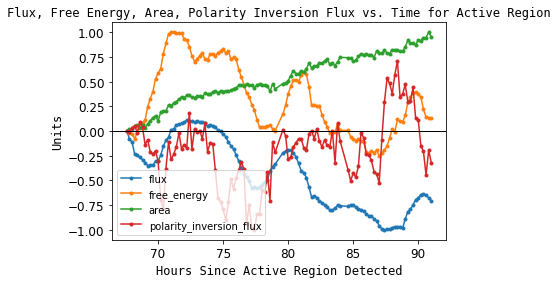

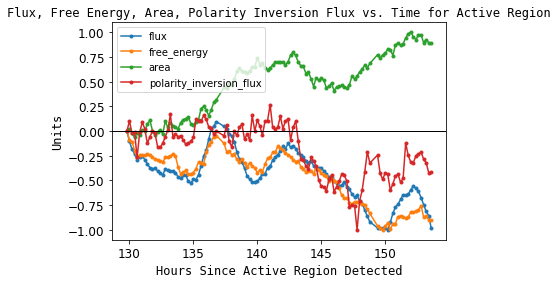

In [91]:
num_graphs = 2
plot_segmented_graphs(seg_x, seg_y, variables=['flux', 'free_energy', 'area',
                                               'polarity_inversion_flux'],
                      scale=True, flare=True, n=num_graphs)

## Spearman Coefficient
(from Wikipedia): Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [112]:
def calculate_spearman(seg_x, first_var, second_var):
    '''Calculate the Spearman coefficient between two variables. This method calculates
    the coefficient between the two variables for every time series data series, then
    returns the mean and standard deviation of the coefficients.
    '''
    s_coeff_list = []
    for data in seg_x:
        first_var_data = []
        second_var_data = []
        for data_pt in data:
            first_var_data.append(data_pt[first_var])
            second_var_data.append(data_pt[second_var])
        s_coeff = scipy.stats.spearmanr(first_var_data, second_var_data).correlation
        if not math.isnan(s_coeff): s_coeff_list.append(s_coeff)
    return numpy.mean(s_coeff_list), numpy.std(s_coeff_list)

In [114]:
for var in ['free_energy', 'area', 'polarity_inversion_flux']:
    s_coeff, s_dev = calculate_spearman(seg_x, 'flux', var)
    print('S_coefficient for flux vs.', var + '. mean:', s_coeff, 'std:', s_dev)

S_coefficient for flux vs. free_energy. mean: 0.47137893677767145 std: 0.5426708484944376
S_coefficient for flux vs. area. mean: 0.1638846438690089 std: 0.6393245298285545
S_coefficient for flux vs. polarity_inversion_flux. mean: 0.1930404255466294 std: 0.4895103043842793
